In [1]:
from spatialkfold.blocks import spatial_blocks 
from spatialkfold.datasets import load_ames
from spatialkfold.clusters import spatial_kfold_clusters 
from spatialkfold.plotting import spatial_kfold_plot
from spatialkfold.stats import spatial_kfold_stats

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold 
from sklearn.model_selection import LeaveOneGroupOut 
from sklearn.model_selection import cross_validate

# I. Spatial Resampling

In [2]:
ames = load_ames()

In [3]:
ames.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
ames

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,geometry
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,None,0,5,2010,WD,Normal,215000,POINT (-93.61975 42.05403)
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,POINT (-93.61976 42.05301)
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,POINT (-93.61939 42.05266)
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,None,0,4,2010,WD,Normal,244000,POINT (-93.61732 42.05125)
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,POINT (-93.63893 42.06090)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,Split_or_Multilevel,Residential_Low_Density,37.0,7937,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,CulDSac,...,No_Pool,Good_Privacy,None,0,3,2006,WD,Normal,142500,POINT (-93.60478 41.98896)
2926,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,0.0,8885,Pave,No_Alley_Access,Slightly_Irregular,Low,AllPub,Inside,...,No_Pool,Minimum_Privacy,None,0,6,2006,WD,Normal,131000,POINT (-93.60268 41.98831)
2927,Split_Foyer,Residential_Low_Density,62.0,10441,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,Shed,700,7,2006,WD,Normal,132000,POINT (-93.60685 41.98651)
2928,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,77.0,10010,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Pool,No_Fence,None,0,4,2006,WD,Normal,170000,POINT (-93.60019 41.99092)


In [5]:
# Reproject to the approriate coordinate reference system 

In [6]:
ames_prj = ames.copy().to_crs(ames.estimate_utm_crs())

In [7]:
ames_prj.crs

<Derived Projected CRS: EPSG:32615>
Name: WGS 84 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 96°W and 90°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Manitoba; Nunavut; Ontario. Ecuador -Galapagos. Guatemala. Mexico. United States (USA).
- bounds: (-96.0, 0.0, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
# Add an id column for each data point 

In [9]:
ames_prj['id'] = range(len(ames_prj))

### 1. Spatial cluster resampling 

In [10]:
ames_clusters = spatial_kfold_clusters (gdf= ames_prj, name = 'id', nfolds = 10, random_state =569) 

In [11]:
ames_clusters

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,geometry,id,folds
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,None,0,5,2010,WD,Normal,215000,POINT (448716.789 4655961.485),0,7
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,None,0,6,2010,WD,Normal,105000,POINT (448715.802 4655848.124),1,7
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,Gar2,12500,6,2010,WD,Normal,172000,POINT (448746.026 4655808.487),2,7
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,None,0,4,2010,WD,Normal,244000,POINT (448915.962 4655650.253),3,7
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,None,0,3,2010,WD,Normal,189900,POINT (447135.458 4656735.276),4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,Split_or_Multilevel,Residential_Low_Density,37.0,7937,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,CulDSac,...,None,0,3,2006,WD,Normal,142500,POINT (449905.137 4648727.785),2925,4
2926,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,0.0,8885,Pave,No_Alley_Access,Slightly_Irregular,Low,AllPub,Inside,...,None,0,6,2006,WD,Normal,131000,POINT (450078.246 4648654.392),2926,4
2927,Split_Foyer,Residential_Low_Density,62.0,10441,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Shed,700,7,2006,WD,Normal,132000,POINT (449731.661 4648456.532),2927,4
2928,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,77.0,10010,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,None,0,4,2006,WD,Normal,170000,POINT (450286.530 4648942.397),2928,4


In [12]:
# Get the 'tab20' colormap
cols_tab = cm.get_cmap('tab20', 10)
# Generate a list of colors from the colormap
cols = [cols_tab(i) for i in range(10)]
# create a color ramp
color_ramp = ListedColormap(cols)

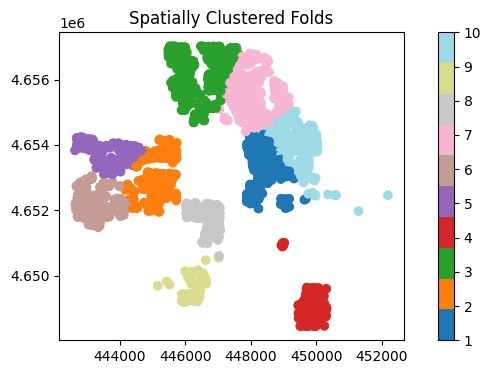

In [13]:
fig, ax = plt.subplots(1,1 , figsize=(9, 4)) 
ames_clusters.plot(column = 'folds', ax = ax, cmap = color_ramp, legend = True)
ax.set_title('Spatially Clustered Folds')
plt.show()

In [14]:
# check the number of train and test of the dependent variable for each folf

In [15]:
ames_clusters_stats = spatial_kfold_stats(ames_clusters, y= ames_clusters.Sale_Price, groups = ames_clusters.folds)


In [16]:
ames_clusters_stats

,split,train,test
0,1,2594,336
1,2,2687,243
2,3,2270,660
3,4,2769,161
4,5,2694,236
5,6,2606,324
6,7,2537,393
7,8,2790,140
8,9,2857,73
9,10,2566,364


### 2. Spatial Blocks

#### 2.1 spatial resampled random blocks

In [17]:
# create 10 random blocks 
ames_rnd_blocks = spatial_blocks(ames_prj, width = 1500, height = 1500, 
                                 method = 'random', nfolds = 10, 
                                 random_state = 135)

Text(0.5, 1.0, 'Random Blocks Folds')

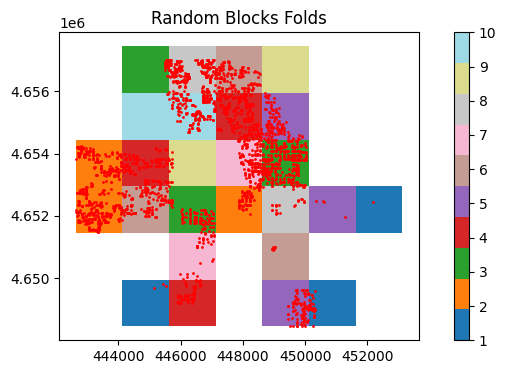

In [18]:
fig, ax = plt.subplots(1,1 , figsize=(9, 4)) 

ames_rnd_blocks.plot(column = 'folds',cmap = color_ramp, ax = ax ,lw=0.7, legend = True)
ames_prj.plot(ax=ax,  markersize = 1, color = 'r')
ax.set_title('Random Blocks Folds')

In [19]:
# resample the ames data with the prepared blocks 
ames_res_rnd_blk = gpd.overlay (ames_prj, ames_rnd_blocks)

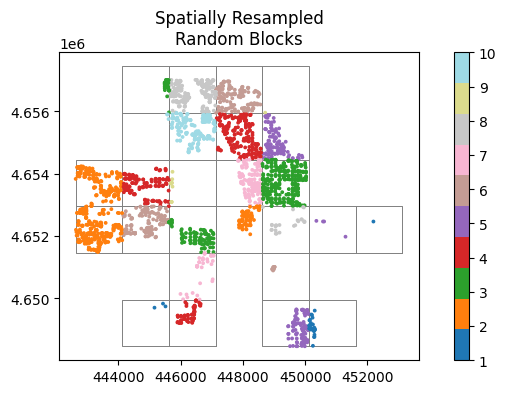

In [20]:
fig, ax = plt.subplots(1,1 , figsize=(9, 4)) 

ames_rnd_blocks.plot(facecolor="none",edgecolor='grey', ax = ax ,lw=0.7)
ames_res_rnd_blk.plot(column = 'folds', cmap = color_ramp,legend = True, ax = ax, markersize = 3)
ax.set_title('Spatially Resampled\nRandom Blocks')
plt.show()

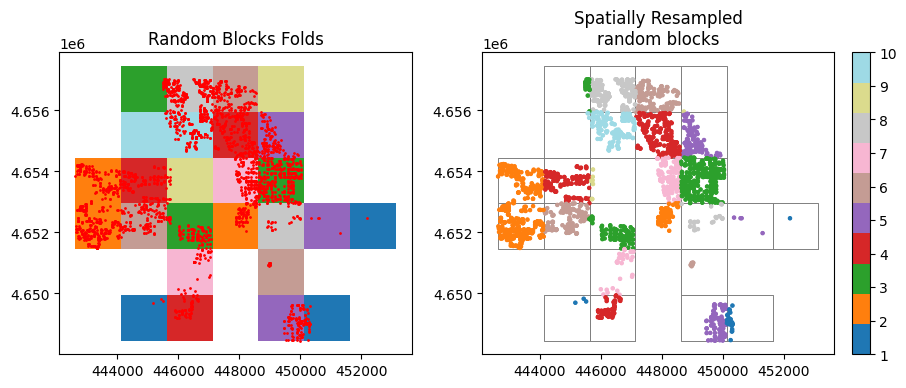

In [21]:
fig, ax = plt.subplots(1,2 , figsize=(10, 6)) 

# plot 1
ames_rnd_blocks.plot(column = 'folds',cmap = color_ramp, ax = ax[0] ,lw=0.7, legend = False)
ames_prj.plot(ax=ax[0],  markersize = 1, color = 'r')
ax[0].set_title('Random Blocks Folds')

# plot 2
ames_rnd_blocks.plot(facecolor="none",edgecolor='grey', ax = ax[1] ,lw=0.7, legend = False)
ames_res_rnd_blk.plot(column = 'folds', cmap = color_ramp,legend = False, ax = ax[1], markersize = 3)
ax[1].set_title('Spatially Resampled\nrandom blocks')


im1 = ax[1].scatter(ames_res_rnd_blk.geometry.x , ames_res_rnd_blk.geometry.y, c=ames_res_rnd_blk['folds'],
                 cmap=color_ramp, s=5)

axins1 = inset_axes(
    ax[1],
    width="5%",  # width: 5% of parent_bbox width
    height="50%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(1.05, 0, 1, 2),
    bbox_transform=ax[1].transAxes,
    borderpad=0
)
fig.colorbar(im1, cax=axins1,  ticks= range(1,11))


plt.show()

In [22]:
ames_res_rnd_blk_stats = spatial_kfold_stats(ames_res_rnd_blk, y= ames_res_rnd_blk.Sale_Price, groups = ames_res_rnd_blk.folds)


In [23]:
ames_res_rnd_blk_stats

,split,train,test
0,1,2893,37
1,2,2371,559
2,3,2414,516
3,4,2472,458
4,5,2687,243
5,6,2608,322
6,7,2720,210
7,8,2589,341
8,9,2920,10
9,10,2696,234


#### 2.2 continuous spatial resampled blocks 

Two option are availble with orientation :
 - 'tb-lr' : top-bottom, left-right
 - ''bt-rl' : bottom-top, right-left

#####  2.2.1. 'tb-lr' : top-bottom, left-right

In [24]:
ames_cont_blocks = spatial_blocks(ames_prj, width = 1500, height = 1500, 
                              method = 'continuous', orientation = 'tb-lr' ,
                              nfolds = 10, random_state = 135)

Text(0.5, 1.0, 'Continuous Blocks Folds\norientation:"tb-lr"')

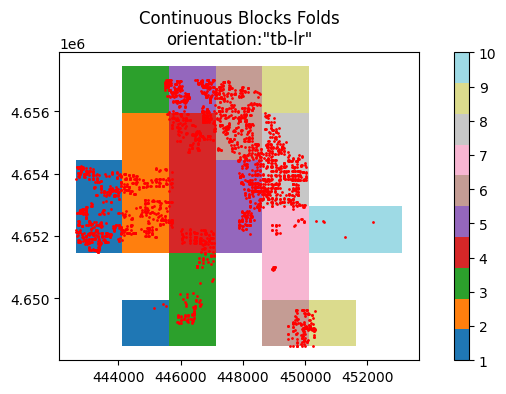

In [25]:
fig, ax = plt.subplots(1,1 , figsize=(9, 4)) 

ames_cont_blocks.plot(column = 'folds',cmap = color_ramp, ax = ax ,lw=0.7, legend = True)
ames_prj.plot(ax=ax,  markersize = 1, color = 'r')
ax.set_title('Continuous Blocks Folds\norientation:"tb-lr"')

In [26]:
# resample the ames data with the prepared blocks 
ames_res_cont_blk = gpd.overlay (ames_prj, ames_cont_blocks)

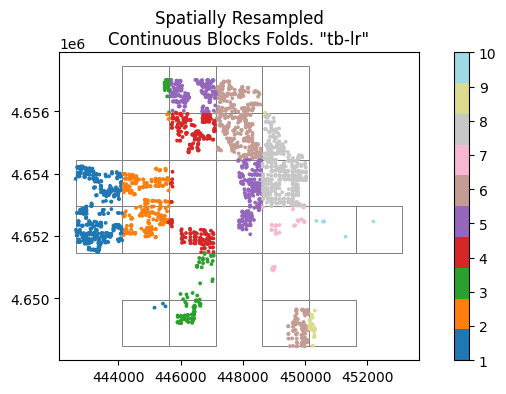

In [27]:
fig, ax = plt.subplots(1,1 , figsize=(9, 4)) 

ames_cont_blocks.plot(facecolor="none",edgecolor='grey', ax = ax ,lw=0.7)
ames_res_cont_blk.plot(column = 'folds', cmap = color_ramp,legend = True, ax = ax, markersize = 3)
ax.set_title('Spatially Resampled\nContinuous Blocks Folds. "tb-lr"')
plt.show()

In [28]:
ames_res_cont_blk_stats = spatial_kfold_stats(ames_res_cont_blk, y= ames_res_cont_blk.Sale_Price, groups = ames_res_cont_blk.folds)


In [29]:
ames_res_cont_blk_stats

,split,train,test
0,1,2446,484
1,2,2628,302
2,3,2801,129
3,4,2567,363
4,5,2367,563
5,6,2402,528
6,7,2894,36
7,8,2444,486
8,9,2896,34
9,10,2925,5


#####  2.2.2. 'bt-rl' : bottom-top, right-left

In [30]:
ames_cont_blocks_rev = spatial_blocks(ames_prj, width = 1500, height = 1500, 
                              method = 'continuous', orientation = 'bt-rl',
                              nfolds = 10, random_state = 135)

Text(0.5, 1.0, 'Continuous Blocks Folds\norientation:"bt-rl"')

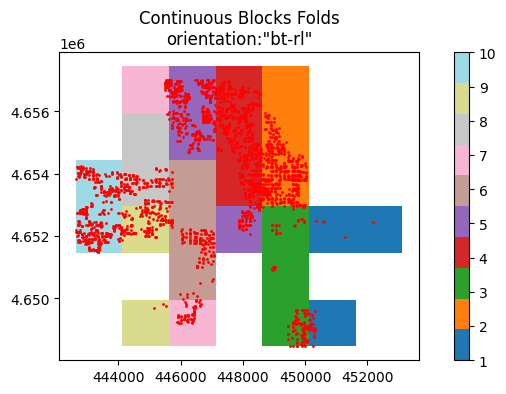

In [31]:
fig, ax = plt.subplots(1,1 , figsize=(9, 4)) 

ames_cont_blocks_rev.plot(column = 'folds',cmap = color_ramp, ax = ax ,lw=0.7, legend = True)
ames_prj.plot(ax=ax,  markersize = 1, color = 'r')
ax.set_title('Continuous Blocks Folds\norientation:"bt-rl"')

In [ ]:
# resample the ames data with the prepared blocks 
ames_res_cont_blk_rev = gpd.overlay (ames_prj, ames_cont_blocks_rev)

In [ ]:
fig, ax = plt.subplots(1,1 , figsize=(9, 4)) 

ames_cont_blocks_rev.plot(facecolor="none",edgecolor='grey', ax = ax ,lw=0.7)
ames_res_cont_blk_rev.plot(column = 'folds', cmap = color_ramp,legend = True, ax = ax, markersize = 3)
ax.set_title('Spatially Resampled\nContinuous Blocks Folds. "bt-rl"')
plt.show()

In [ ]:
ames_res_cont_blk_rev_stats = spatial_kfold_stats(ames_res_cont_blk_rev, y= ames_res_cont_blk_rev.Sale_Price, groups = ames_res_cont_blk_rev.folds)


In [ ]:
ames_res_cont_blk_rev_stats

### 3. Flotting function 

visiaulise the partitioning of the data at each fold

In [ ]:
# checn the folds number 
np.unique(ames_clusters.folds.values)

In [ ]:
for i in range(1,11):
    fig, ax = plt.subplots(1,1 , figsize= (9, 4))

    spatial_kfold_plot(ames_clusters, 
                       ames_clusters.geometry, 
                       groups= ames_clusters.folds, 
                       fold_num = i, cmap = 'viridis', ax = ax)

## II. Comparaison : Random VS Spatial Cross validataion

In [ ]:
x = ames_prj[['Year_Built', 'Bldg_Type', 'Gr_Liv_Area']]
y = ames_prj[['Sale_Price']]

le = preprocessing.LabelEncoder()
le.fit(x["Bldg_Type"])

list(le.classes_)

le.transform(ames_prj["Bldg_Type"])

In [ ]:
# Create a copy of the DataFrame and transform the 'Bldg_Type' column to float values
x_copy = x.copy()
x_copy['type'] = le.transform(x_copy["Bldg_Type"])

In [ ]:
# Get the independent variable and the dependent variable
X = x_copy[['Year_Built', 'type', 'Gr_Liv_Area']]
y = ames_prj[['Sale_Price']]

In [ ]:
X

In [ ]:
y

#### 1. Random CV

In [ ]:
# initiate a linear regressor 
reg = LinearRegression()

# initiate a random CV
kf = KFold(n_splits = 10, shuffle=True, random_state=123)

# evaluate the model and collect the results
random_n_scores = cross_validate(reg, X, y.values.ravel(), 
                                scoring= ['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error'], 
                                cv=kf, n_jobs=-1, error_score='raise')

In [ ]:
random_n_scores

In [ ]:
rn_cv_r2 = np.mean(random_n_scores["test_r2"])
rn_cv_rmse = np.mean(abs(random_n_scores["test_neg_root_mean_squared_error"]))
rn_cv_mae = np.mean(abs(random_n_scores["test_neg_mean_absolute_error"]))

print('R2 :',rn_cv_r2)
print('RMSE :',rn_cv_rmse)
print('MAE :',rn_cv_mae)

#### Spatial CV:

using a Leave Region Out Cross vlidation 

In [ ]:
# Initiate a leave group out cross valiadtion
group_cvs =  LeaveOneGroupOut()

# evaluate the model and collect the results
spatial_cluster_scores = cross_validate(reg, X, y.values.ravel(), 
                                scoring= ['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error'], 
                                cv= group_cvs.split(X, y, ames_clusters.folds.values.ravel()), # spatial cross validation
                                n_jobs=-1, error_score='raise')

In [ ]:
spatial_cluster_scores

In [ ]:
sp_cv_r2 = np.mean(spatial_cluster_scores["test_r2"])
sp_cv_rmse = np.mean(abs(spatial_cluster_scores["test_neg_root_mean_squared_error"]))
sp_cv_mae = np.mean(abs(spatial_cluster_scores["test_neg_mean_absolute_error"]))

print('R2 :',sp_cv_r2)
print('RMSE :',sp_cv_rmse)
print('MAE :',sp_cv_mae)

In [ ]:
random_n_scores['test_r2']

In [ ]:
df_rn_cv_scores = pd.DataFrame({'r2': random_n_scores['test_r2'], 
             'rmse' :abs(random_n_scores['test_neg_root_mean_squared_error']),
             'mae' : abs(random_n_scores["test_neg_mean_absolute_error"]),
            'cv_type' : 'Random CV'})

In [ ]:
df_rn_cv_scores

In [ ]:
df_sp_cv_scores = pd.DataFrame({'r2': spatial_cluster_scores['test_r2'], 
             'rmse' :abs(spatial_cluster_scores['test_neg_root_mean_squared_error']),
             'mae' : abs(spatial_cluster_scores["test_neg_mean_absolute_error"]),
            'cv_type' : 'Spatial CV'})

In [ ]:
df_sp_cv_scores

In [ ]:
cv_metrics = pd.concat([df_rn_cv_scores, df_sp_cv_scores])

In [ ]:
cv_metrics

In [ ]:
fig, ax =  plt.subplots(1, 3,figsize=(12, 4))

my_colors = {'Random CV': '#1f77b4', 'Spatial CV': '#ff7f0e', 'C': 'gold'}

sns.boxplot(data = cv_metrics,
            hue = 'cv_type', 
            x = 'cv_type',
            y = 'r2',  
            dodge=False, width = .3, linewidth = 1, ax = ax[0],
            #palette= 'coolwarm',
            palette = my_colors,
            showmeans=True, meanprops={"markersize": "2.5", "markerfacecolor" : "#ef3b2c",
                    "markeredgecolor" : "#ef3b2c"} ,flierprops=dict(markersize=3))

ax[0].set_title( r'$R^2$',fontsize=11)
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_ylim(0, 1)
ax[0].tick_params(labelsize = 9)
ax[0].legend([],[], frameon=False)

#
sns.boxplot(data = cv_metrics,
            hue = 'cv_type', 
            x = 'cv_type',
            y = 'rmse',  
            dodge=False, width = .3, linewidth = 1, ax = ax[1],
            #palette= 'coolwarm',
            palette = my_colors,
           showmeans=True, meanprops={"markersize": "2.5",  "markerfacecolor" : "#ef3b2c",
                    "markeredgecolor" : "#ef3b2c"},  flierprops=dict(markersize=3))
ax[1].set_title('RMSE',fontsize=11)
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].tick_params(labelsize = 9)
ax[1].legend([],[], frameon=False)

sns.boxplot(data = cv_metrics,
            hue = 'cv_type',
            x = 'cv_type',
            y = 'mae',  
            dodge=False, width = .3, linewidth = 1, ax = ax[2],
            #palette= 'coolwarm',
            palette = my_colors,
           showmeans=True, meanprops={"markersize": "2.5",  "markerfacecolor" : "#ef3b2c",
                    "markeredgecolor" : "#ef3b2c"},  flierprops=dict(markersize=3))
ax[2].set_title('MAE',fontsize=11)
ax[2].set_ylabel('')
ax[2].set_xlabel('')
ax[2].tick_params(labelsize = 9)

plt.legend([],[], frameon=False)
plt.show()